In [1]:
!pip3 install scikit-learn

You should consider upgrading via the '/Volumes/Kerja_Keras/Folder_Fold_Recovery/For Learning/Bootcamp Binar/GoldChallange_Binar/gold_binar/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
btc = yf.download('BTC-USD', start='2010-01-01')
gold = yf.download('GC=F',start = '2010-01-01')
sp500 = yf.download('^GSPC', start='2010-01-01')
nasdaq = yf.download('^IXIC', start='2010-01-01')
usm2 = pd.read_csv("M2SL.csv")

usm2['DATE'] = pd.to_datetime(usm2['DATE'])
usm2 = usm2.set_index('DATE')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.concat([btc['Adj Close'], gold['Adj Close'], sp500['Adj Close'], nasdaq['Adj Close']], axis=1)
df = pd.concat([df,usm2['M2SL']],axis=1)
df.columns = ['BTC', 'Gold', 'S&P500', 'NASDAQ','M2SL']

In [5]:
df.dropna(inplace = True)

In [6]:
df

,BTC,Gold,S&P500,NASDAQ,M2SL
2014-10-01,383.614990,1214.599976,1946.160034,4422.089844,11566.0
2014-12-01,379.244995,1218.000000,2053.439941,4727.350098,11684.9
2015-04-01,247.272003,1208.099976,2059.689941,4880.229980,11928.9
2015-05-01,232.078995,1174.500000,2108.290039,5005.390137,11957.9
2015-06-01,222.925995,1188.300049,2111.729980,5082.930176,12001.7
...,...,...,...,...,...
2022-09-01,20127.140625,1696.599976,3966.850098,11785.129883,21523.1
2022-11-01,20485.273438,1645.000000,3856.100098,10890.849609,21396.9
2022-12-01,16967.132812,1801.099976,4076.570068,11482.450195,21357.7
2023-02-01,23723.769531,1927.800049,4119.209961,11816.320312,21075.4


In [7]:
perubahan_btc = ((df['BTC'][-1]-df['BTC'][0])/df['BTC'][0])*100
perubahan_gold = ((df['Gold'][-1]-df['Gold'][0])/df['Gold'][0])*100
perubahan_sp500 = ((df['S&P500'][-1]-df['S&P500'][0])/df['S&P500'][0])*100
perubahan_nasdaq = ((df['NASDAQ'][-1]-df['NASDAQ'][0])/df['NASDAQ'][0])*100
perubahan_M2SL = ((df['M2SL'][-1]-df['M2SL'][0])/usm2['M2SL'][0])*100

In [8]:
list_Asset = ['BTC','GOLD','SP500','NASDAQ','M2SL']
nilai_perubahan = [perubahan_btc,perubahan_gold,perubahan_sp500,perubahan_nasdaq,perubahan_M2SL]

Text(0, 0.5, 'Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ')

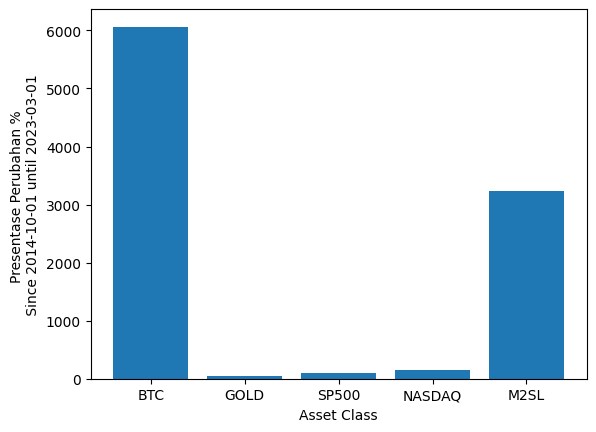

In [9]:
plt.figure(1)
plt.bar(list_Asset,nilai_perubahan)
plt.xlabel("Asset Class")
plt.ylabel("Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ")

In [10]:
# Mencari Korelasi Antara Asset Tersebut

In [11]:
corr = df.corr()

In [12]:
corr

,BTC,Gold,S&P500,NASDAQ,M2SL
BTC,1.000000,0.766714,0.897872,0.918841,0.837029
Gold,0.766714,1.000000,0.896406,0.911007,0.945620
S&P500,0.897872,0.896406,1.000000,0.984172,0.962452
NASDAQ,0.918841,0.911007,0.984172,1.000000,0.951484
M2SL,0.837029,0.945620,0.962452,0.951484,1.000000


Text(0.5, 1.0, 'Heat-map Korelasi Silang Antar Asset')

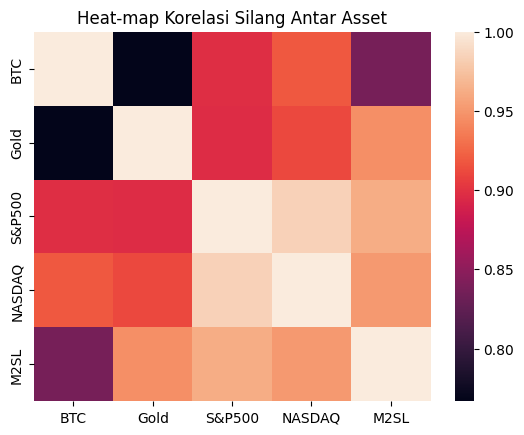

In [13]:
plt.figure(2)
sns.heatmap(corr)
plt.title("Heat-map Korelasi Silang Antar Asset")

In [14]:
# Prediksi Harga Bitcoin Menggunakan Tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import MinMaxScaler

2023-05-08 16:05:30.362304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [17]:
time = df.index
btc_price = np.asarray(df['BTC'].values)
min = np.min(btc_price)
max = np.max(btc_price)
btc_price -=min
btc_price /=max

In [18]:
splitting = int(0.8*len(df))
y_train = btc_price[:splitting]
y_test = btc_price[splitting:]
time_train = time[:splitting]
time_test = time[splitting:]

In [19]:
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
train_set = windowed_dataset(y_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(y_test, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [21]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [22]:
model = tf.keras.models.Sequential()
model.add(LSTM(3, input_shape=(None, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', run_eagerly=True)
history=model.fit(train_set,epochs=1000,verbose=2,validation_data=test_set)

Epoch 1/1000


2023-05-08 16:05:34.609228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:05:34.612683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:05:34.614707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 - 0s - loss: 0.1257 - val_loss: 0.9474 - 233ms/epoch - 117ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.1217 - val_loss: 0.9257 - 112ms/epoch - 56ms/step
Epoch 3/1000


2023-05-08 16:05:34.878276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [14,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 16:05:34.878651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [14,1]
	 [[{{node Placeholder/_0}}]]


2/2 - 0s - loss: 0.1180 - val_loss: 0.9047 - 123ms/epoch - 62ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.1139 - val_loss: 0.8843 - 120ms/epoch - 60ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.1105 - val_loss: 0.8642 - 121ms/epoch - 60ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.1074 - val_loss: 0.8444 - 121ms/epoch - 60ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.1046 - val_loss: 0.8254 - 125ms/epoch - 62ms/step
Epoch 8/1000
2/2 - 0s - loss: 0.1014 - val_loss: 0.8074 - 118ms/epoch - 59ms/step
Epoch 9/1000
2/2 - 0s - loss: 0.0987 - val_loss: 0.7900 - 114ms/epoch - 57ms/step
Epoch 10/1000
2/2 - 0s - loss: 0.0962 - val_loss: 0.7735 - 114ms/epoch - 57ms/step
Epoch 11/1000
2/2 - 0s - loss: 0.0936 - val_loss: 0.7578 - 116ms/epoch - 58ms/step
Epoch 12/1000
2/2 - 0s - loss: 0.0916 - val_loss: 0.7427 - 118ms/epoch - 59ms/step
Epoch 13/1000
2/2 - 0s - loss: 0.0892 - val_loss: 0.7283 - 118ms/epoch - 59ms/step
Epoch 14/1000
2/2 - 0s - loss: 0.0872 - val_loss: 0.7142 - 115ms/epoch - 58ms/step
Epoch 15/1000
2/2 - 0s -

Epoch 102/1000
2/2 - 0s - loss: 0.0397 - val_loss: 0.3128 - 111ms/epoch - 55ms/step
Epoch 103/1000
2/2 - 0s - loss: 0.0393 - val_loss: 0.3110 - 109ms/epoch - 55ms/step
Epoch 104/1000
2/2 - 0s - loss: 0.0390 - val_loss: 0.3092 - 109ms/epoch - 55ms/step
Epoch 105/1000
2/2 - 0s - loss: 0.0387 - val_loss: 0.3074 - 114ms/epoch - 57ms/step
Epoch 106/1000
2/2 - 0s - loss: 0.0384 - val_loss: 0.3056 - 114ms/epoch - 57ms/step
Epoch 107/1000
2/2 - 0s - loss: 0.0381 - val_loss: 0.3037 - 116ms/epoch - 58ms/step
Epoch 108/1000
2/2 - 0s - loss: 0.0378 - val_loss: 0.3019 - 113ms/epoch - 57ms/step
Epoch 109/1000
2/2 - 0s - loss: 0.0375 - val_loss: 0.3002 - 114ms/epoch - 57ms/step
Epoch 110/1000
2/2 - 0s - loss: 0.0371 - val_loss: 0.2986 - 112ms/epoch - 56ms/step
Epoch 111/1000
2/2 - 0s - loss: 0.0368 - val_loss: 0.2970 - 111ms/epoch - 56ms/step
Epoch 112/1000
2/2 - 0s - loss: 0.0366 - val_loss: 0.2953 - 111ms/epoch - 55ms/step
Epoch 113/1000
2/2 - 0s - loss: 0.0362 - val_loss: 0.2936 - 115ms/epoch - 58

Epoch 200/1000
2/2 - 0s - loss: 0.0116 - val_loss: 0.0731 - 116ms/epoch - 58ms/step
Epoch 201/1000
2/2 - 0s - loss: 0.0116 - val_loss: 0.0717 - 116ms/epoch - 58ms/step
Epoch 202/1000
2/2 - 0s - loss: 0.0115 - val_loss: 0.0705 - 144ms/epoch - 72ms/step
Epoch 203/1000
2/2 - 0s - loss: 0.0114 - val_loss: 0.0694 - 114ms/epoch - 57ms/step
Epoch 204/1000
2/2 - 0s - loss: 0.0114 - val_loss: 0.0683 - 111ms/epoch - 55ms/step
Epoch 205/1000
2/2 - 0s - loss: 0.0113 - val_loss: 0.0672 - 111ms/epoch - 55ms/step
Epoch 206/1000
2/2 - 0s - loss: 0.0113 - val_loss: 0.0662 - 111ms/epoch - 56ms/step
Epoch 207/1000
2/2 - 0s - loss: 0.0112 - val_loss: 0.0653 - 110ms/epoch - 55ms/step
Epoch 208/1000
2/2 - 0s - loss: 0.0112 - val_loss: 0.0643 - 114ms/epoch - 57ms/step
Epoch 209/1000
2/2 - 0s - loss: 0.0111 - val_loss: 0.0634 - 112ms/epoch - 56ms/step
Epoch 210/1000
2/2 - 0s - loss: 0.0111 - val_loss: 0.0626 - 111ms/epoch - 55ms/step
Epoch 211/1000
2/2 - 0s - loss: 0.0110 - val_loss: 0.0619 - 114ms/epoch - 57

Epoch 298/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0451 - 115ms/epoch - 57ms/step
Epoch 299/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0450 - 130ms/epoch - 65ms/step
Epoch 300/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0449 - 114ms/epoch - 57ms/step
Epoch 301/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0449 - 112ms/epoch - 56ms/step
Epoch 302/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0448 - 110ms/epoch - 55ms/step
Epoch 303/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0447 - 122ms/epoch - 61ms/step
Epoch 304/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0447 - 113ms/epoch - 56ms/step
Epoch 305/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0447 - 110ms/epoch - 55ms/step
Epoch 306/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0446 - 110ms/epoch - 55ms/step
Epoch 307/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0446 - 109ms/epoch - 54ms/step
Epoch 308/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0446 - 111ms/epoch - 56ms/step
Epoch 309/1000
2/2 - 0s - loss: 0.0102 - val_loss: 0.0446 - 112ms/epoch - 56

Epoch 396/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 114ms/epoch - 57ms/step
Epoch 397/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 111ms/epoch - 55ms/step
Epoch 398/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 110ms/epoch - 55ms/step
Epoch 399/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 111ms/epoch - 55ms/step
Epoch 400/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 111ms/epoch - 55ms/step
Epoch 401/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 111ms/epoch - 55ms/step
Epoch 402/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 116ms/epoch - 58ms/step
Epoch 403/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 113ms/epoch - 56ms/step
Epoch 404/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 111ms/epoch - 55ms/step
Epoch 405/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 112ms/epoch - 56ms/step
Epoch 406/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 112ms/epoch - 56ms/step
Epoch 407/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 110ms/epoch - 55

Epoch 494/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 123ms/epoch - 62ms/step
Epoch 495/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 110ms/epoch - 55ms/step
Epoch 496/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 109ms/epoch - 54ms/step
Epoch 497/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 108ms/epoch - 54ms/step
Epoch 498/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 111ms/epoch - 55ms/step
Epoch 499/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0429 - 113ms/epoch - 57ms/step
Epoch 500/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 115ms/epoch - 57ms/step
Epoch 501/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 112ms/epoch - 56ms/step
Epoch 502/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 112ms/epoch - 56ms/step
Epoch 503/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 113ms/epoch - 56ms/step
Epoch 504/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 113ms/epoch - 56ms/step
Epoch 505/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0428 - 115ms/epoch - 57

Epoch 592/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 112ms/epoch - 56ms/step
Epoch 593/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 109ms/epoch - 55ms/step
Epoch 594/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 109ms/epoch - 54ms/step
Epoch 595/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 112ms/epoch - 56ms/step
Epoch 596/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0430 - 111ms/epoch - 55ms/step
Epoch 597/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 110ms/epoch - 55ms/step
Epoch 598/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 110ms/epoch - 55ms/step
Epoch 599/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 111ms/epoch - 56ms/step
Epoch 600/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0431 - 109ms/epoch - 55ms/step
Epoch 601/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0432 - 111ms/epoch - 55ms/step
Epoch 602/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0432 - 113ms/epoch - 57ms/step
Epoch 603/1000
2/2 - 0s - loss: 0.0101 - val_loss: 0.0432 - 112ms/epoch - 56

Epoch 690/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0428 - 110ms/epoch - 55ms/step
Epoch 691/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0428 - 112ms/epoch - 56ms/step
Epoch 692/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0429 - 113ms/epoch - 57ms/step
Epoch 693/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0429 - 120ms/epoch - 60ms/step
Epoch 694/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0429 - 116ms/epoch - 58ms/step
Epoch 695/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0429 - 112ms/epoch - 56ms/step
Epoch 696/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 119ms/epoch - 60ms/step
Epoch 697/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 109ms/epoch - 54ms/step
Epoch 698/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 111ms/epoch - 56ms/step
Epoch 699/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 111ms/epoch - 55ms/step
Epoch 700/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 126ms/epoch - 63ms/step
Epoch 701/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 110ms/epoch - 55

Epoch 788/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 113ms/epoch - 56ms/step
Epoch 789/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 114ms/epoch - 57ms/step
Epoch 790/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 110ms/epoch - 55ms/step
Epoch 791/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 112ms/epoch - 56ms/step
Epoch 792/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 111ms/epoch - 56ms/step
Epoch 793/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 110ms/epoch - 55ms/step
Epoch 794/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 109ms/epoch - 54ms/step
Epoch 795/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 109ms/epoch - 55ms/step
Epoch 796/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 112ms/epoch - 56ms/step
Epoch 797/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 113ms/epoch - 56ms/step
Epoch 798/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0433 - 109ms/epoch - 54ms/step
Epoch 799/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0432 - 109ms/epoch - 54

Epoch 886/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 111ms/epoch - 56ms/step
Epoch 887/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 110ms/epoch - 55ms/step
Epoch 888/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0432 - 111ms/epoch - 56ms/step
Epoch 889/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0432 - 109ms/epoch - 54ms/step
Epoch 890/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 116ms/epoch - 58ms/step
Epoch 891/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 110ms/epoch - 55ms/step
Epoch 892/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0431 - 112ms/epoch - 56ms/step
Epoch 893/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 113ms/epoch - 56ms/step
Epoch 894/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 110ms/epoch - 55ms/step
Epoch 895/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 111ms/epoch - 56ms/step
Epoch 896/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 114ms/epoch - 57ms/step
Epoch 897/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0430 - 111ms/epoch - 56

Epoch 984/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0427 - 112ms/epoch - 56ms/step
Epoch 985/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 114ms/epoch - 57ms/step
Epoch 986/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 112ms/epoch - 56ms/step
Epoch 987/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0425 - 110ms/epoch - 55ms/step
Epoch 988/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0425 - 111ms/epoch - 56ms/step
Epoch 989/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0425 - 111ms/epoch - 56ms/step
Epoch 990/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 111ms/epoch - 56ms/step
Epoch 991/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 113ms/epoch - 56ms/step
Epoch 992/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 114ms/epoch - 57ms/step
Epoch 993/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 114ms/epoch - 57ms/step
Epoch 994/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 114ms/epoch - 57ms/step
Epoch 995/1000
2/2 - 0s - loss: 0.0100 - val_loss: 0.0426 - 109ms/epoch - 55

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [24]:
xdat = np.array([btc_price[i:i+3].reshape(-1, 1) for i in range(len(btc_price)-2)])

In [25]:
prediksi_awal = xdat[-1]

In [26]:
prediksi_awal.shape

(3, 1)

In [27]:
prediction=np.zeros((50,1))
for i in range(50):
    pred = model.predict(prediksi_awal.T)
    prediction[i] = pred
    prediksi_awal = np.concatenate((prediksi_awal, pred), axis=0)

1/1 [==============================] - 0s 62ms/step


In [28]:
prediction

array([[0.26183286],
       [0.28133702],
       [0.29808456],
       [0.31081855],
       [0.3209489 ],
       [0.32934636],
       [0.33653316],
       [0.34283122],
       [0.34844574],
       [0.35351235],
       [0.35812402],
       [0.36234745],
       [0.36623195],
       [0.36981544],
       [0.37312809],
       [0.37619445],
       [0.37903512],
       [0.38166764],
       [0.38410738],
       [0.38636792],
       [0.38846138],
       [0.39039889],
       [0.39219055],
       [0.39384583],
       [0.39537343],
       [0.39678156],
       [0.39807802],
       [0.39927009],
       [0.40036467],
       [0.40136829],
       [0.40228713],
       [0.40312701],
       [0.40389365],
       [0.40459216],
       [0.40522763],
       [0.40580472],
       [0.4063279 ],
       [0.40680131],
       [0.40722898],
       [0.40761453],
       [0.40796143],
       [0.40827295],
       [0.40855214],
       [0.40880179],
       [0.40902454],
       [0.40922275],
       [0.40939873],
       [0.409

Text(0.5, 1.0, 'Analisis Harga BTCUSD')

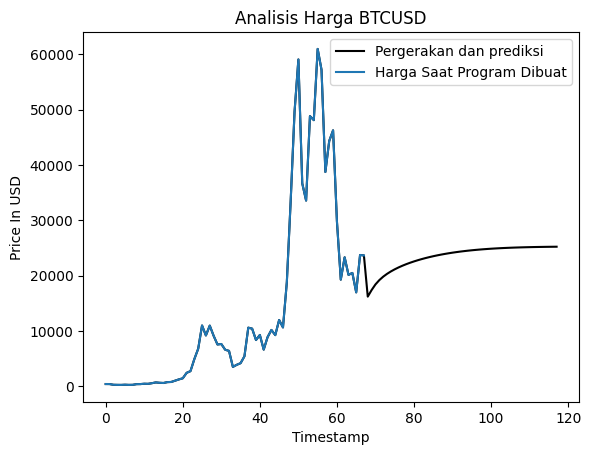

In [29]:
plt.figure(3)
plt.plot((np.vstack([btc_price.reshape(-1,1),prediction.reshape(-1,1)]))*max+min,color=(0,0,0),label="Pergerakan dan prediksi")
plt.plot(btc_price.reshape(-1,1)*max+min,label="Harga Saat Program Dibuat")
plt.xlabel("Timestamp")
plt.ylabel("Price In USD")
plt.legend()
plt.title("Analisis Harga BTCUSD")

In [30]:
btc_price.shape

(68,)

In [31]:
prediction.shape

(50, 1)